WTA data from Kaggle - 2000 to 2016

In [1]:
import time
import numpy as np
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn import svm
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.ticker as plticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [2]:
df = pd.read_csv('combined.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36456 entries, 0 to 36455
Data columns (total 49 columns):
best_of               36456 non-null int64
draw_size             36456 non-null int64
l_1stIn               19768 non-null float64
l_1stWon              19768 non-null float64
l_2ndWon              19768 non-null float64
l_SvGms               103 non-null float64
l_ace                 19761 non-null float64
l_bpFaced             19766 non-null float64
l_bpSaved             19766 non-null float64
l_df                  19732 non-null float64
l_svpt                19767 non-null float64
loser_age             36452 non-null float64
loser_entry           7524 non-null object
loser_hand            35825 non-null object
loser_ht              22367 non-null float64
loser_id              36456 non-null int64
loser_ioc             36456 non-null object
loser_name            36456 non-null object
loser_rank            34773 non-null float64
loser_rank_points     34773 non-null float64
lose

In [4]:
df = df.drop(columns=["tourney_date", "match_num", "winner_id", "winner_seed", "tourney_level", "winner_ioc",\
                                    "winner_rank_points", "winner_entry","winner_name", "loser_id", "loser_seed", "loser_rank_points", "loser_entry", "loser_ioc",\
                                    "score", "round", "loser_name", "minutes","surface", "winner_hand", "winner_ht", "winner_age", "winner_rank", "loser_hand", "loser_ht",\
                                    "loser_age", "loser_rank" ])
df1 = df.replace(np.nan, 0, regex=True)
df = df1
df.info()
filtered_df = df
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36456 entries, 0 to 36455
Data columns (total 22 columns):
best_of         36456 non-null int64
draw_size       36456 non-null int64
l_1stIn         36456 non-null float64
l_1stWon        36456 non-null float64
l_2ndWon        36456 non-null float64
l_SvGms         36456 non-null float64
l_ace           36456 non-null float64
l_bpFaced       36456 non-null float64
l_bpSaved       36456 non-null float64
l_df            36456 non-null float64
l_svpt          36456 non-null float64
tourney_id      36456 non-null object
tourney_name    36456 non-null object
w_1stIn         36456 non-null float64
w_1stWon        36456 non-null float64
w_2ndWon        36456 non-null float64
w_SvGms         36456 non-null float64
w_ace           36456 non-null float64
w_bpFaced       36456 non-null float64
w_bpSaved       36456 non-null float64
w_df            36456 non-null float64
w_svpt          36456 non-null float64
dtypes: float64(18), int64(2), object(2

Index(['best_of', 'draw_size', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt', 'tourney_id',
       'tourney_name', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_ace',
       'w_bpFaced', 'w_bpSaved', 'w_df', 'w_svpt'],
      dtype='object')

In [5]:
lost_df = filtered_df[['l_ace', 'l_df', 'l_svpt','l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']]
won_df = filtered_df[['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon','w_SvGms', 'w_bpSaved', 'w_bpFaced']]
lost_df = lost_df.rename(columns={'l_ace':'ace', 'l_df':'df', 'l_svpt':'svpt','l_1stIn':'1stIn', 'l_1stWon':'1stWon', 'l_2ndWon':'2ndWon', \
                                  'l_SvGms':'SvGms', 'l_bpSaved':'bpSaved', 'l_bpFaced':'bpFaced'})
won_df = won_df.rename(columns={'w_ace':'ace', 'w_df':'df', 'w_svpt':'svpt','w_1stIn':'1stIn', 'w_1stWon':'1stWon', 'w_2ndWon':'2ndWon',\
                                'w_SvGms':'SvGms', 'w_bpSaved':'bpSaved', 'w_bpFaced':'bpFaced'})

won_df["won"] = won_df['svpt']**0
lost_df["won"] = lost_df['svpt']*0

big_df = pd.concat([won_df, lost_df], ignore_index=True)
big_df = big_df.drop(columns=['svpt'])
display(big_df.head())

,ace,df,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,won
0,3.0,0.0,24.0,17.0,10.0,0.0,3.0,4.0,1.0
1,2.0,10.0,58.0,32.0,15.0,0.0,4.0,12.0,1.0
2,4.0,2.0,44.0,29.0,13.0,0.0,6.0,10.0,1.0
3,4.0,2.0,31.0,23.0,12.0,0.0,1.0,2.0,1.0
4,7.0,6.0,66.0,48.0,32.0,0.0,8.0,13.0,1.0


In [6]:
big_df['won'].value_counts()

0.0    36456
1.0    36456
Name: won, dtype: int64

In [7]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72912 entries, 0 to 72911
Data columns (total 9 columns):
ace        72912 non-null float64
df         72912 non-null float64
1stIn      72912 non-null float64
1stWon     72912 non-null float64
2ndWon     72912 non-null float64
SvGms      72912 non-null float64
bpSaved    72912 non-null float64
bpFaced    72912 non-null float64
won        72912 non-null float64
dtypes: float64(9)
memory usage: 5.0 MB


In [8]:
def split_test_train(train_size, all_data):
    msk = np.random.rand(len(all_data)) < train_size
    train_df = all_data[msk]
    test_df = all_data[~msk]
    train_y = train_df["won"]
    train_x = train_df.drop("won", axis=1)
    test_y = test_df["won"]
    test_x  = test_df.drop("won", axis=1)
    return (train_x, train_y, test_x, test_y)
def eval_for_conclusion(model_id, clf, test_x, test_y):
    y_pred = clf.predict(test_x)
    print(confusion_matrix(test_y, y_pred))
    accuracy = metrics.accuracy_score(test_y, y_pred)
    precision = metrics.precision_score(test_y, y_pred)
    recall = metrics.recall_score(test_y, y_pred)
    print("Final {0} model accuracy:".format(model_id), accuracy)
    print("Final {0} model precision:".format(model_id), precision) 
    print("Final {0} model recall:".format(model_id), recall) 
    return {"model":model_id, "recall":recall, "accuracy":accuracy, "precision":precision}

def cross_validate(all_data, model):
    depth = []
    all_y = all_data["won"]
    all_x  = all_data.drop("won", axis=1)
    for i in range(2,10):
        scores = cross_val_score(estimator=model, X=all_x, y=all_y, cv=i, n_jobs=4)
        depth.append((i,scores.mean()))
    return depth
    
def train_and_test(all_data, model):
    test_scores = []
    train_scores = []
    times = []
    for i in range(1,10):
        (train_x, train_y, test_x, test_y) = split_test_train(0.1 * i, big_df)
        start = time.time()
        model.fit(train_x, train_y)
        end = time.time()
        times.append(end - start)
        pred_test_y = model.predict(test_x) # TODO add wallclock time
        test_score = round(model.score(test_x, test_y) * 100, 2)
        pred_train_y = model.predict(train_x)
        train_score = round(model.score(train_x, train_y) * 100, 2)
        test_scores.append(test_score)
        train_scores.append(train_score)
    return (test_scores, train_scores, times)

def plot_data(x_vars, x_label, all_y_vars, y_var_labels, y_label, title, y_bounds=None):
    plt.rcParams["figure.figsize"] = (4,3)

    i = 0
    for y_var in all_y_vars:
        plt.plot(x_vars, y_var, label=y_var_labels[i])
        i += 1
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if y_bounds != None:
        plt.ylim(y_bounds)
    leg = plt.legend();
    plt.show()

def evaluate_model(all_data, model, model_id):
    (test_scores, train_scores, times) = train_and_test(all_data, model)
    cv_scores = cross_validate(all_data, model)
    """print("{0} train timings (seconds): {1}".format(model_id, times))"""
    print("{0} test set scores: {1} ".format(model_id, test_scores))
    print("{0} train set scores: {1}".format(model_id, train_scores))
    print("{0} cross validation set scores: {1}".format(model_id, cv_scores))
    plot_data([x * 10 for x in range(1,10)], "Percentage of data in training set", [test_scores, train_scores],\
              ["test_scores", "train_scores"], "Accuracy", "{0} Accuracy Over Train/Test Split".format(model_id), (50,103))
    plot_data([x[0] for x in cv_scores], "Number of folds", [[x[1] for x in cv_scores]],
             ["cross_validation_accuracy"], "Accuracy", "{0} Accuracy Over Different Cross Validation Values of K".format(model_id), (0.3,1))
    return (test_scores, train_scores, times, cv_scores)

def plot_grid_search(grid_results, plotting_func, title, x_label, y_label, grid_size, model_handles):
    plt.rcParams["figure.figsize"] = grid_size
    means = grid_results.cv_results_['mean_test_score']
    stds = grid_results.cv_results_['std_test_score']
    params = grid_results.cv_results_['params']
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.subplots
    ax = plt.subplot()
    for mean, std, params in zip(means, stds, params):
        plotting_func(mean, params, plt, ax)
    if handles: plt.legend(handles=model_handles)
    plt.show()


Decision Tree test set scores: [63.64, 63.8, 63.63, 63.61, 64.07, 63.8, 63.66, 63.86, 64.34] 
Decision Tree train set scores: [77.37, 77.49, 77.53, 77.25, 77.2, 77.28, 77.1, 77.11, 77.1]
Decision Tree cross validation set scores: [(2, 0.6376865262233926), (3, 0.6383859995611147), (4, 0.640991880623217), (5, 0.6384981845154641), (6, 0.6388797454465658), (7, 0.6392363396971693), (8, 0.6392500548606539), (9, 0.6401832161206618)]


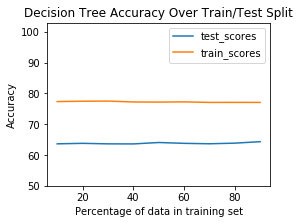

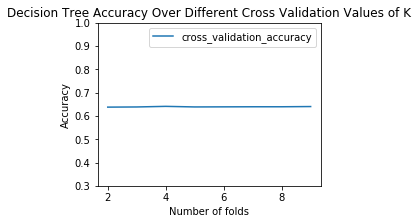

In [9]:
dt_model = DecisionTreeClassifier()
(dt_test_scores, dt_train_scores, dt_times, dt_cv_scores) = evaluate_model(big_df, dt_model, "Decision Tree")
optimal_test_split = dt_test_scores.index(max(dt_test_scores)) * 0.1
(dt_grid_train_x, dt_grid_train_y, dt_grid_test_x, dt_grid_test_y) = split_test_train(optimal_test_split, big_df)


dt_param_grid = {"criterion":["gini","entropy"], "max_depth":[x for x in range(2,31)], "min_samples_split":[3,5,7]}  #"splitter":["best", "random"], 

dt_grid_results = GridSearchCV(dt_model, dt_param_grid, cv=5).fit(dt_grid_train_x, dt_grid_train_y)

In [10]:
print(confusion_matrix(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x)))
print("DT model accuracy:", metrics.accuracy_score(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x))) 
print("DT model precision:", metrics.precision_score(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x))) 
print("DT model recall:", metrics.recall_score(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x))) 

[[6562  696]
 [4283 3047]]
DT model accuracy: 0.65869207567864
DT model precision: 0.8140528987443227
DT model recall: 0.41568894952251023


KNN test set scores: [64.76, 64.81, 65.09, 65.19, 65.4, 65.45, 64.87, 65.23, 65.03] 
KNN train set scores: [68.42, 68.76, 69.17, 69.04, 69.12, 69.05, 69.24, 69.3, 69.31]
KNN cross validation set scores: [(2, 0.6532806671055519), (3, 0.6525537634408601), (4, 0.6532532367785824), (5, 0.6526387799323974), (6, 0.6542132982225148), (7, 0.6541721527320605), (8, 0.6532806671055519), (9, 0.6537613466708249)]


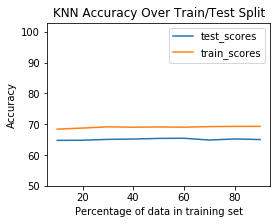

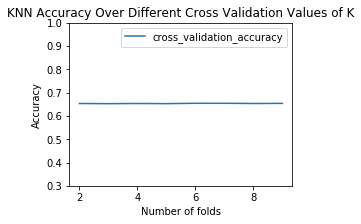

Best parameters found:
 {'n_neighbors': 100} with score of:  0.6622318994633704
[[3128 4213]
 [ 609 6635]]
Final KNN model accuracy: 0.6693863558450462
Final KNN model precision: 0.6116334808259587
Final KNN model recall: 0.9159304251794589


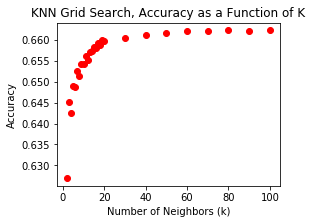

In [11]:
knn_classifier = KNeighborsClassifier()
evaluate_model(big_df, knn_classifier, "KNN")
knn_param_grid = {"n_neighbors":[x for x in range (2,21)] + [y*10 for y in range(3,11)]}
(knn_grid_train_x, knn_grid_train_y, knn_grid_test_x, knn_grid_test_y) = split_test_train(0.8, big_df)
knn_grid_results = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5).fit(knn_grid_train_x, knn_grid_train_y)

plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Grid Search, Accuracy as a Function of K")
knn_means = knn_grid_results.cv_results_['mean_test_score']
knn_stds = knn_grid_results.cv_results_['std_test_score']
knn_params = knn_grid_results.cv_results_['params']
k_vals = []
knn_accuracies = []
for mean, std, params in zip(knn_means, knn_stds, knn_params):
    knn_accuracies.append(mean)
    k_vals.append(params["n_neighbors"])
print('Best parameters found:\n', knn_grid_results.best_params_, "with score of: ", max(knn_grid_results.cv_results_['mean_test_score']))

    
eval_for_conclusion("KNN", knn_grid_results, knn_grid_test_x, knn_grid_test_y)

    
plt.plot(k_vals, knn_accuracies, 'o', color="red")
plt.show()    

C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: Fut

SVM test set scores: [64.33, 65.56, 65.76, 65.93, 66.06, 66.03, 66.19, 66.3, 65.42] 
SVM train set scores: [76.74, 75.53, 74.7, 74.67, 74.2, 74.09, 73.91, 73.58, 73.54]
SVM cross validation set scores: [(2, 0.6592056177309633), (3, 0.660097103357472), (4, 0.6621269475532149), (5, 0.6618006570067034), (6, 0.662552117621242), (7, 0.6627304147465437), (8, 0.6629087118718455), (9, 0.6634167214381519)]


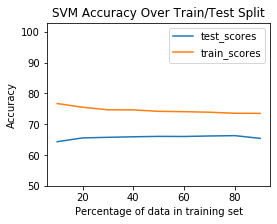

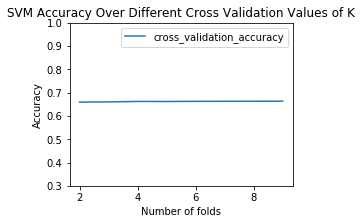

([64.33, 65.56, 65.76, 65.93, 66.06, 66.03, 66.19, 66.3, 65.42],
 [76.74, 75.53, 74.7, 74.67, 74.2, 74.09, 73.91, 73.58, 73.54],
 [1.4822285175323486,
  6.871560096740723,
  19.136833667755127,
  33.844308853149414,
  53.26056456565857,
  74.1764178276062,
  99.19955563545227,
  140.98520016670227,
  231.49955010414124],
 [(2, 0.6592056177309633),
  (3, 0.660097103357472),
  (4, 0.6621269475532149),
  (5, 0.6618006570067034),
  (6, 0.662552117621242),
  (7, 0.6627304147465437),
  (8, 0.6629087118718455),
  (9, 0.6634167214381519)])

In [12]:
svm_classifier = svm.SVC()
evaluate_model(big_df, svm_classifier, "SVM")

In [13]:
svm_parameter_space = {
    'kernel': ['linear', 'rbf'],
    'C': [ float(i) / 100 for i in range (1, 300, 5)]+[5,7,9],    
}
svm_grid_clf = GridSearchCV(svm_classifier, svm_parameter_space, n_jobs=-1, cv=3)
(svm_train_x, svm_train_y, svm_test_x, svm_test_y) = split_test_train(0.1 * 8, big_df)
scaler = StandardScaler()
scaler.fit(svm_train_x)
svm_train_x = scaler.transform(svm_train_x)
svm_test_x = scaler.transform(svm_test_x)
svm_grid_clf.fit(svm_train_x, svm_train_y)

print("best params ", svm_grid_clf.best_params_)
svm_grid_score = svm_grid_clf.score(svm_test_x,svm_test_y)
print("SVM grid search model test set score: ", svm_grid_score)
print('Best SVM parameters found (cv):\n', svm_grid_clf.best_params_, "with score of: ", max(svm_grid_clf.cv_results_['mean_test_score']))


best params  {'C': 1.16, 'kernel': 'linear'}
SVM grid search model test set score:  0.6784622699178157
Best SVM parameters found (cv):
 {'C': 1.16, 'kernel': 'linear'} with score of:  0.6745604839402636


Adaboost test set scores: [66.46, 66.25, 66.48, 65.96, 66.57, 66.38, 66.11, 66.23, 66.12] 
Adaboost train set scores: [66.39, 66.94, 66.14, 67.03, 66.83, 66.92, 66.84, 66.66, 66.93]
Adaboost cross validation set scores: [(2, 0.6645408163265306), (3, 0.6651031380294053), (4, 0.6656654597322801), (5, 0.6657370375923908), (6, 0.6659260478384903), (7, 0.6653774412991004), (8, 0.6654734474434936), (9, 0.6658857217933623)]


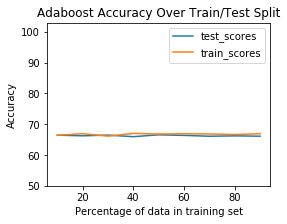

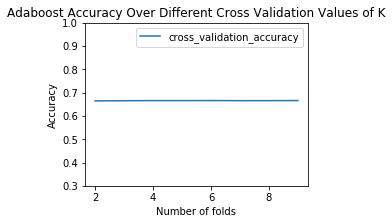

([66.46, 66.25, 66.48, 65.96, 66.57, 66.38, 66.11, 66.23, 66.12],
 [66.39, 66.94, 66.14, 67.03, 66.83, 66.92, 66.84, 66.66, 66.93],
 [0.13204693794250488,
  0.2404952049255371,
  0.34973788261413574,
  0.44043540954589844,
  0.5738513469696045,
  0.6984989643096924,
  0.8171119689941406,
  0.9559059143066406,
  1.144207239151001],
 [(2, 0.6645408163265306),
  (3, 0.6651031380294053),
  (4, 0.6656654597322801),
  (5, 0.6657370375923908),
  (6, 0.6659260478384903),
  (7, 0.6653774412991004),
  (8, 0.6654734474434936),
  (9, 0.6658857217933623)])

In [14]:
boost_classifier = AdaBoostClassifier()
evaluate_model(big_df, boost_classifier, "Adaboost")

In [15]:
boost_parameter_space = {
    'n_estimators': [i*10 for i in range(5,11)],
    'learning_rate': [ float(i) / 100 for i in range (1, 150, 10)]
}
boost_grid_clf = GridSearchCV(boost_classifier, boost_parameter_space, n_jobs=-1, cv=3)
(boost_train_x, boost_train_y, boost_test_x, boost_test_y) = split_test_train(0.1 * 8, big_df)
scaler = StandardScaler()
scaler.fit(boost_train_x)
boost_train_x = scaler.transform(boost_train_x)
boost_test_x = scaler.transform(boost_test_x)
boost_grid_clf.fit(boost_train_x, boost_train_y)

print("best Boost params ", boost_grid_clf.best_params_)
boost_grid_score = boost_grid_clf.score(boost_test_x,boost_test_y)
print("Bost grid search model test set score: ", boost_grid_score)
print('Best Boost parameters found through cv:\n', boost_grid_clf.best_params_, "with score of: ", max(boost_grid_clf.cv_results_['mean_test_score']))


best Boost params  {'learning_rate': 1.31, 'n_estimators': 100}
Bost grid search model test set score:  0.6707793543080403
Best Boost parameters found through cv:
 {'learning_rate': 1.31, 'n_estimators': 100} with score of:  0.6700615537609519


In [16]:
def plotting_func_boost(mean, params, plt, ax):
    x_var = "learning_rate"
    cmap = cm.hot
    norm = Normalize(vmin=-110, vmax=-20)
    ax.plot(params[x_var], mean,"o", color=cmap(norm(-1*params["n_estimators"])))
    
cmap = cm.hot
norm = Normalize(vmin=-110, vmax=-20)
yellow_patch = mpatches.Patch(color=cmap(norm(-50)), label='n_estimators=50')
red_patch = mpatches.Patch(color=cmap(norm(-80)), label='n_estimators=80')
black_patch = mpatches.Patch(color=cmap(norm(-110)), label='n_estimators=110')
handles = [yellow_patch, red_patch, black_patch] #[linear, rbf]#, red_patch, orange_patch, black_patch]


eval_for_conclusion("AdaBoosting", boost_grid_clf, boost_test_x, boost_test_y)

[[6567  768]
 [4035 3219]]
Final AdaBoosting model accuracy: 0.6707793543080403
Final AdaBoosting model precision: 0.8073739653875094
Final AdaBoosting model recall: 0.4437551695616212


{'model': 'AdaBoosting',
 'recall': 0.4437551695616212,
 'accuracy': 0.6707793543080403,
 'precision': 0.8073739653875094}

In [21]:
eval_df = pd.DataFrame(columns=["model", "accuracy", "recall", "precision"])
print("Confusion Matrix for Decision Tree")
eval_df = eval_df.append(eval_for_conclusion("Decision Tree", dt_grid_results, dt_grid_test_x, dt_grid_test_y), ignore_index=True)
print("\n\nConfusion Matrix for SVM")
eval_df = eval_df.append(eval_for_conclusion("SVM", svm_grid_clf, svm_test_x, svm_test_y), ignore_index=True)
print("\n\nConfusion Matrix for AdaBoosting")
eval_df = eval_df.append(eval_for_conclusion("AdaBoosting", boost_grid_clf, boost_test_x, boost_test_y), ignore_index=True)
print("\n\nConfusion Matrix for KNN")
eval_df = eval_df.append(eval_for_conclusion("KNN", knn_grid_results, knn_grid_test_x, knn_grid_test_y), ignore_index=True)
eval_df.head()

Confusion Matrix for Decision Tree
[[6562  696]
 [4283 3047]]
Final Decision Tree model accuracy: 0.65869207567864
Final Decision Tree model precision: 0.8140528987443227
Final Decision Tree model recall: 0.41568894952251023


Confusion Matrix for SVM
[[3385 4040]
 [ 694 6604]]
Final SVM model accuracy: 0.6784622699178157
Final SVM model precision: 0.6204434423149192
Final SVM model recall: 0.9049054535489175


Confusion Matrix for AdaBoosting
[[6567  768]
 [4035 3219]]
Final AdaBoosting model accuracy: 0.6707793543080403
Final AdaBoosting model precision: 0.8073739653875094
Final AdaBoosting model recall: 0.4437551695616212


Confusion Matrix for KNN
[[3128 4213]
 [ 609 6635]]
Final KNN model accuracy: 0.6693863558450462
Final KNN model precision: 0.6116334808259587
Final KNN model recall: 0.9159304251794589


,model,accuracy,recall,precision
0,Decision Tree,0.658692,0.415689,0.814053
1,SVM,0.678462,0.904905,0.620443
2,AdaBoosting,0.670779,0.443755,0.807374
3,KNN,0.669386,0.915930,0.611633
